In [98]:
import numpy as np
import matplotlib.pyplot as plt

class TicTacToe:
    
    def __init__(self, N=3):
        self.N = N
        self.board = np.zeros((N, N))
        self.action_space = [i for i in range(N*N)]
        self.num_actions = len(self.action_space)
        self.num_states = 5478 #3**(N**2)
        
    def step(self, action, player=1):
        self.board = self.get_new_state(self.board, action, player=player)
        won = self.check_board(player)
        done = won or (self.board != 0).all()
        if won:
            reward = 5
            self.reset_board()
        else:
            reward = -1
        return self.board, reward, done
        
    def check_board(self, player):
        won = False
        for i in range(self.N):
            won = (self.board[i,:] == player).all() or (self.board[:, i] == player).all()
            if won:
                break
        # Check diagonals
        won = won or np.diag(self.board == player).all() or np.diag(np.fliplr(self.board) == player).all()
        return won
        
    def reset_board(self):
        self.board = np.zeros((self.N, self.N))
        return self.board
        
    def get_idx(self, action):
        return (action//self.N, action % self.N)
    
    def sample_action(self):
        return np.random.choice(self.num_actions)
    
    def state_to_idx(self, state):
        return int(np.sum(3**state.flatten()))
    
    def play_game(self, player1, player2):
        hist = [self.reset_board().copy()]
        done = False
        while not done:
            action = player1.get_action(hist[-1], eps=0)
            state, _, done = self.step(action, player=1)
            hist.append(action)
            hist.append(state.copy())
            if done:
                break
            action = player2.get_action(hist[-1], eps=0)
            state, _, done = self.step(action, player=2)
            hist.append(action)
            hist.append(state.copy())
        return hist
    
    def possible_actions(self, state):
        return np.argwhere(state.flatten() == 0).flatten()
    
    def get_new_state(self, state, action, player=1):
        s = state.copy()
        idx = self.get_idx(action)
        s[idx[0], idx[1]] = player
        return s


In [99]:
class QLearning:
    def __init__(self, env):
        self.env = env
        self.Q = np.zeros((env.num_states, env.num_actions))
        
    def update(self, state, action, reward, state_prime, alpha=0.5, gamma=1):
        state_idx = self.env.state_to_idx(state)
        state_prime_idx = self.env.state_to_idx(state_prime)
        self.Q[state_idx, action] += alpha*(reward + gamma * np.amax(self.Q[state_prime_idx, ]) - self.Q[state_idx, action])
        
    def get_action(self, state, eps=0.1):
        state_idx = self.env.state_to_idx(state)
        possible_actions = self.env.possible_actions(state)
        if eps <= np.random.uniform():
            action = np.random.choice(possible_actions)
        else:
            action = np.argmax(self.Q[state_idx, possible_actions])
            action = possible_actions[action]
        return action


In [109]:
class AfterstateAgent:
    def __init__(self, env):
        self.env = env
        self.W = np.zeros(env.num_states)
        
    def update(self, state, action, reward, state_prime, alpha=0.5, gamma=1):
        state_idx = self.env.state_to_idx(state)
        state_prime_idx = self.env.state_to_idx(state_prime)
        self.W[state_idx] += alpha*(reward + gamma * self.W[state_prime_idx] - self.W[state_idx])
    
    def get_action(self, state, eps=0.1, player=2):
        possible_actions = self.env.possible_actions(state)
        if eps <= np.random.uniform():
            action = np.random.choice(possible_actions)
        else:
            state_idxs = [self.env.state_to_idx(self.env.get_new_state(state, a, player=2)) for a in possible_actions]
            values = np.array([self.W[idx] for idx in state_idxs])
            action_idx = np.argmax(values)
            action = possible_actions[action_idx]
        return action
    

In [112]:
ttt = TicTacToe(N=3)

episodes = 5000
alpha = 0.5
eps = 0.3
gamma = 1

Q = AfterstateAgent(ttt)
W = AfterstateAgent(ttt)
P1 = []
P2 = []

Episode 5000: Player 1 -0.346, Player 2 -0.333

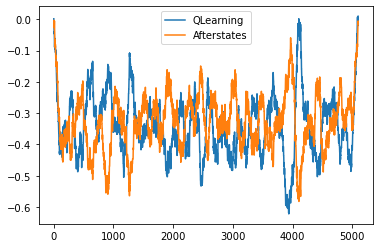

In [113]:
for episode in range(episodes):
    state = ttt.reset_board()
    done = False
    p1returns = []
    p2returns = []
    while not done:
        action = Q.get_action(state)
        new_state, reward, done = ttt.step(action, player=1)
        Q.update(state, action, reward, new_state, alpha=alpha, gamma=gamma)
        
        p1returns.append(reward)
        if done:
            break

        action = W.get_action(state)
        state, reward, done = ttt.step(action, player=2)
        W.update(new_state, action, reward, state, alpha=alpha, gamma=gamma)
        
        p2returns.append(reward)
        
    P1.append(np.mean(p1returns))
    P2.append(np.mean(p2returns))
        
    if (episode+1) % 500 == 0:
        r1 = (np.cumsum(P1)/np.arange(1, episode+2))[-1]
        r2 = (np.cumsum(P2)/np.arange(1, episode+2))[-1]
        print("\rEpisode %d: Player 1 %0.3f, Player 2 %0.3f" % (episode+1, r1, r2), end="")
        
plt.plot(np.convolve(P1, np.ones(100)/100), label="QLearning")
plt.plot(np.convolve(P2, np.ones(100)/100), label="Afterstates")
plt.legend()

In [114]:
ttt.play_game(Q, W)

[array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 3,
 array([[0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.]]),
 7,
 array([[0., 0., 0.],
        [1., 0., 0.],
        [0., 2., 0.]]),
 8,
 array([[0., 0., 0.],
        [1., 0., 0.],
        [0., 2., 1.]]),
 6,
 array([[0., 0., 0.],
        [1., 0., 0.],
        [2., 2., 1.]]),
 4,
 array([[0., 0., 0.],
        [1., 1., 0.],
        [2., 2., 1.]]),
 1,
 array([[0., 2., 0.],
        [1., 1., 0.],
        [2., 2., 1.]]),
 5,
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

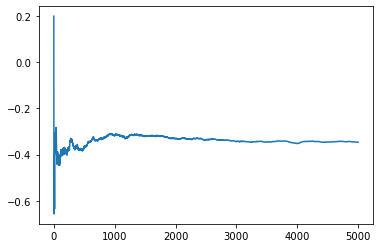

In [115]:
plt.plot(np.cumsum(P1)/np.arange(1, episodes+1))

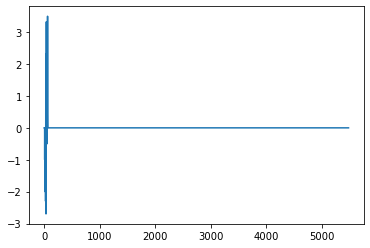

In [116]:
plt.plot(Q.W)